In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
%load_ext tensorboard

hyperparam_tunning = False

In [2]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return mcc

def features_correlation(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals, _ = chi2(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()

In [3]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features_RDKIT.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_RDKIT.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_RDKIT.npy"))

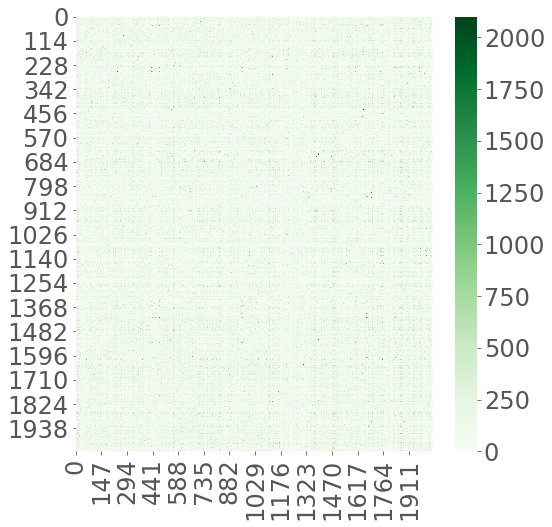

In [4]:
features_correlation(features_shared)

In [5]:
feat_select = SelectPercentile(chi2, percentile=10)
shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
only_2c9_reduced = feat_select.transform(features_only_2c9)
only_3a4_reduced = feat_select.transform(features_only_3a4)

threshold = 0.9
sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
features_shared = sel.fit_transform(features_shared)
features_only_2c9 = sel.transform(features_only_2c9)
features_only_3a4 = sel.transform(features_only_3a4)

combined_filters = VarianceThreshold(threshold=(threshold * (1 - threshold)))
shared_reduced_comb = combined_filters.fit_transform(shared_reduced)
only_2c9_reduced_comb = combined_filters.transform(only_2c9_reduced)
only_3a4_reduced_comb = combined_filters.transform(only_3a4_reduced)

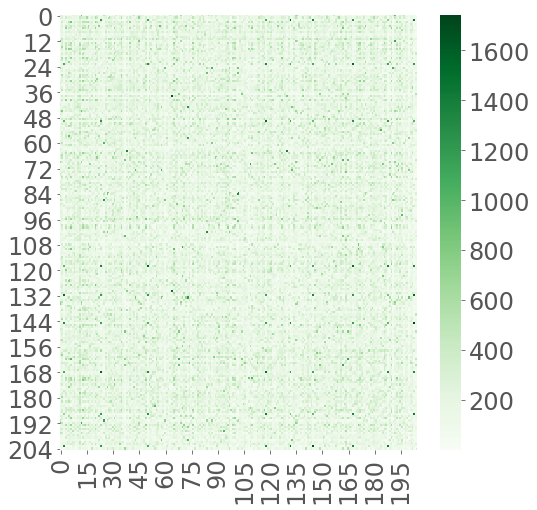

In [6]:
features_correlation(shared_reduced)

We try selecting the top features, moving the percentile value

In [7]:
hidden_layers = 4
neurons = 130
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 103 features
NER: 0.735, Sensitivity or recall: 0.682, Specificity: 0.789, Precision: 0.605, Correctly calssified: 0.755, MCC: 0.457
Testing
NER: 0.680, Sensitivity or recall: 0.635, Specificity: 0.726, Precision: 0.567, Correctly calssified: 0.693, MCC: 0.353
Validation set with 10 percentile, 205 features
NER: 0.742, Sensitivity or recall: 0.620, Specificity: 0.864, Precision: 0.684, Correctly calssified: 0.786, MCC: 0.497
Testing
NER: 0.668, Sensitivity or recall: 0.521, Specificity: 0.816, Precision: 0.615, Correctly calssified: 0.709, MCC: 0.351
Validation set with 15 percentile, 307 features
NER: 0.624, Sensitivity or recall: 0.301, Specificity: 0.947, Precision: 0.731, Correctly calssified: 0.740, MCC: 0.343
Testing
NER: 0.588, Sensitivity or recall: 0.240, Specificity: 0.935, Precision: 0.678, Correctly calssified: 0.684, MCC: 0.252
Validation set with 20 percentile, 409 features
NER: 0.767, Sensitivity or recall: 0.803, Specificity: 0.731, Pre

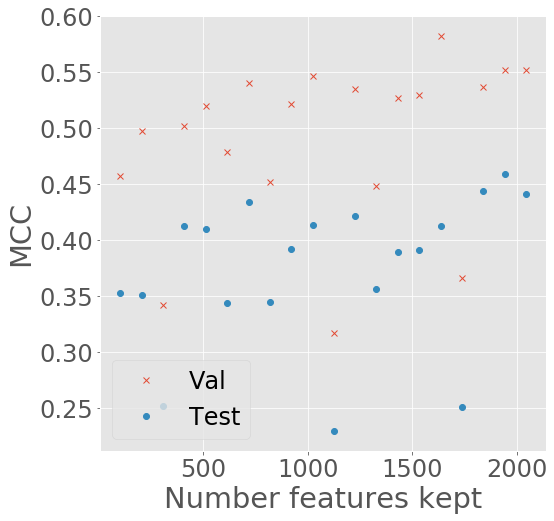

In [8]:
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 103 features
NER: 0.755, Sensitivity or recall: 0.646, Specificity: 0.864, Precision: 0.692, Correctly calssified: 0.794, MCC: 0.519
Testing
NER: 0.688, Sensitivity or recall: 0.540, Specificity: 0.835, Precision: 0.649, Correctly calssified: 0.728, MCC: 0.393
Validation set with 10 percentile, 205 features
NER: 0.764, Sensitivity or recall: 0.646, Specificity: 0.882, Precision: 0.722, Correctly calssified: 0.806, MCC: 0.545
Testing
NER: 0.703, Sensitivity or recall: 0.579, Specificity: 0.826, Precision: 0.653, Correctly calssified: 0.737, MCC: 0.417
Validation set with 15 percentile, 307 features
NER: 0.768, Sensitivity or recall: 0.654, Specificity: 0.882, Precision: 0.724, Correctly calssified: 0.808, MCC: 0.551
Testing
NER: 0.708, Sensitivity or recall: 0.591, Specificity: 0.825, Precision: 0.656, Correctly calssified: 0.740, MCC: 0.426
Validation set with 20 percentile, 409 features
NER: 0.784, Sensitivity or recall: 0.694, Specificity: 0.874, Pre

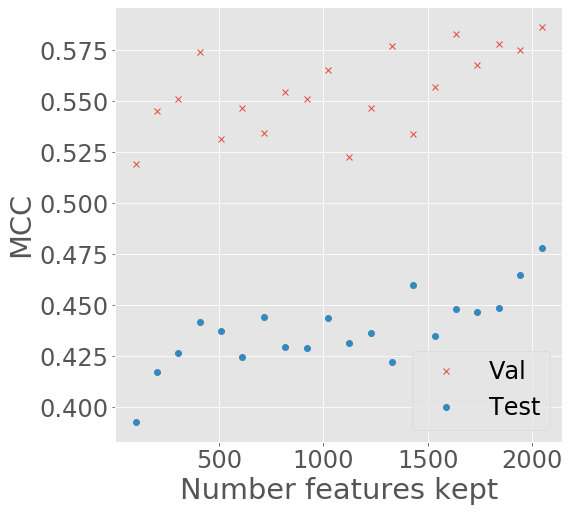

In [9]:
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = SVC(C=8, kernel="rbf")
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 103 features
Testing
Validation set with 10 percentile, 205 features
Testing
Validation set with 15 percentile, 307 features
Testing
Validation set with 20 percentile, 409 features
Testing
Validation set with 25 percentile, 511 features
Testing
Validation set with 30 percentile, 613 features
Testing
Validation set with 35 percentile, 716 features
Testing
Validation set with 40 percentile, 818 features
Testing
Validation set with 45 percentile, 920 features
Testing
Validation set with 50 percentile, 1022 features
Testing
Validation set with 55 percentile, 1124 features
Testing
Validation set with 60 percentile, 1226 features
Testing
Validation set with 65 percentile, 1328 features
Testing
Validation set with 70 percentile, 1431 features
Testing
Validation set with 75 percentile, 1533 features
Testing
Validation set with 80 percentile, 1635 features
Testing
Validation set with 85 percentile, 1737 features
Testing
Validation set with 90 percentile, 1839 f

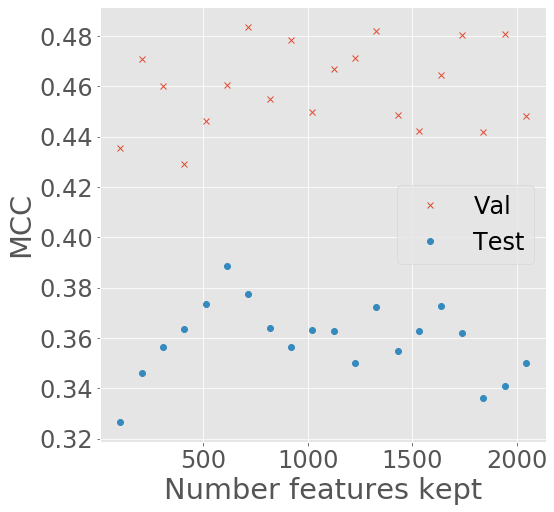

In [10]:
from sklearn.neighbors import KNeighborsClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = KNeighborsClassifier()
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 103 features
Testing
Validation set with 10 percentile, 205 features
Testing
Validation set with 15 percentile, 307 features
Testing
Validation set with 20 percentile, 409 features
Testing
Validation set with 25 percentile, 511 features
Testing
Validation set with 30 percentile, 613 features
Testing
Validation set with 35 percentile, 716 features
Testing
Validation set with 40 percentile, 818 features
Testing
Validation set with 45 percentile, 920 features
Testing
Validation set with 50 percentile, 1022 features
Testing
Validation set with 55 percentile, 1124 features
Testing
Validation set with 60 percentile, 1226 features
Testing
Validation set with 65 percentile, 1328 features
Testing
Validation set with 70 percentile, 1431 features
Testing
Validation set with 75 percentile, 1533 features
Testing
Validation set with 80 percentile, 1635 features
Testing
Validation set with 85 percentile, 1737 features
Testing
Validation set with 90 percentile, 1839 f

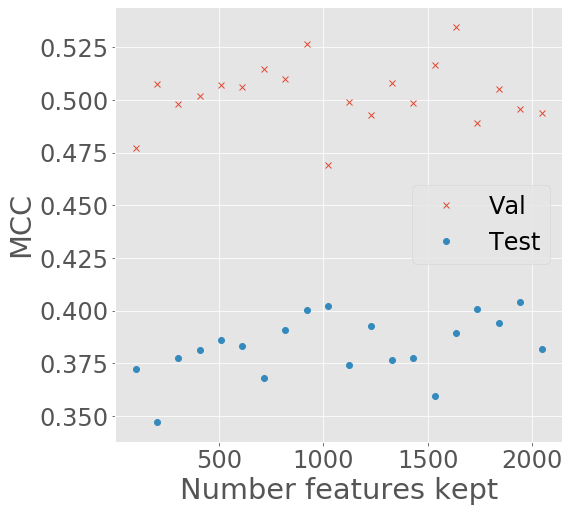

In [11]:
from sklearn.ensemble import RandomForestClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = RandomForestClassifier()
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Now we filter features according to variance, given that the input is binary, we use the variance formula for the Bernouilli probability distribution v=p*(1-p)

In [12]:
percentiles = [0.1*i for i in range(1, 10)]
MCCs = []
MCC_test = []
for percentile in percentiles:
    sel = VarianceThreshold(threshold=(percentile * (1 - percentile)))
    try:
        shared_reduced = sel.fit_transform(features_shared)
    except ValueError:
        MCCs.append(np.nan)
        MCC_test.append(np.nan)
        continue
    only_2c9_reduced = sel.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 0.1 percentile, 2044 features
NER: 0.794, Sensitivity or recall: 0.888, Specificity: 0.700, Precision: 0.583, Correctly calssified: 0.760, MCC: 0.549
Testing
NER: 0.727, Sensitivity or recall: 0.841, Specificity: 0.613, Precision: 0.551, Correctly calssified: 0.695, MCC: 0.438
Validation set with 0.2 percentile, 2013 features
NER: 0.810, Sensitivity or recall: 0.820, Specificity: 0.799, Precision: 0.659, Correctly calssified: 0.806, MCC: 0.591
Testing
NER: 0.742, Sensitivity or recall: 0.747, Specificity: 0.738, Precision: 0.617, Correctly calssified: 0.741, MCC: 0.470
Validation set with 0.30000000000000004 percentile, 1482 features
NER: 0.726, Sensitivity or recall: 0.520, Specificity: 0.931, Precision: 0.782, Correctly calssified: 0.799, MCC: 0.514
Testing
NER: 0.678, Sensitivity or recall: 0.463, Specificity: 0.894, Precision: 0.711, Correctly calssified: 0.738, MCC: 0.404
Validation set with 0.4 percentile, 552 features
NER: 0.719, Sensitivity or recall: 0.514,

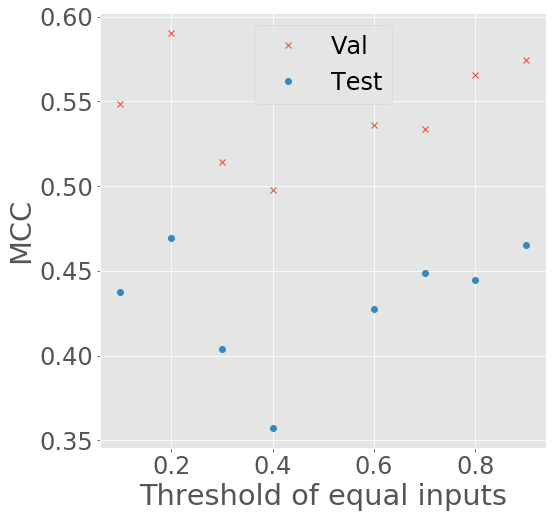

In [13]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Threshold of equal inputs")
plt.legend(loc="upper center")

We now combine the two feature selectors, setting the variance one at threshold 0.1

In [14]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    shared_reduced = sel.fit_transform(shared_reduced)
    only_2c9_reduced = sel.transform(only_2c9_reduced)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 103 features
NER: 0.729, Sensitivity or recall: 0.630, Specificity: 0.827, Precision: 0.633, Correctly calssified: 0.764, MCC: 0.458
Testing
NER: 0.666, Sensitivity or recall: 0.551, Specificity: 0.781, Precision: 0.588, Correctly calssified: 0.698, MCC: 0.337
Validation set with 10 percentile, 205 features
NER: 0.697, Sensitivity or recall: 0.515, Specificity: 0.878, Precision: 0.667, Correctly calssified: 0.761, MCC: 0.425
Testing
NER: 0.652, Sensitivity or recall: 0.464, Specificity: 0.841, Precision: 0.622, Correctly calssified: 0.705, MCC: 0.330
Validation set with 15 percentile, 307 features
NER: 0.700, Sensitivity or recall: 0.478, Specificity: 0.922, Precision: 0.745, Correctly calssified: 0.780, MCC: 0.462
Testing
NER: 0.620, Sensitivity or recall: 0.361, Specificity: 0.879, Precision: 0.628, Correctly calssified: 0.692, MCC: 0.285
Validation set with 20 percentile, 409 features
NER: 0.624, Sensitivity or recall: 0.291, Specificity: 0.958, Pre

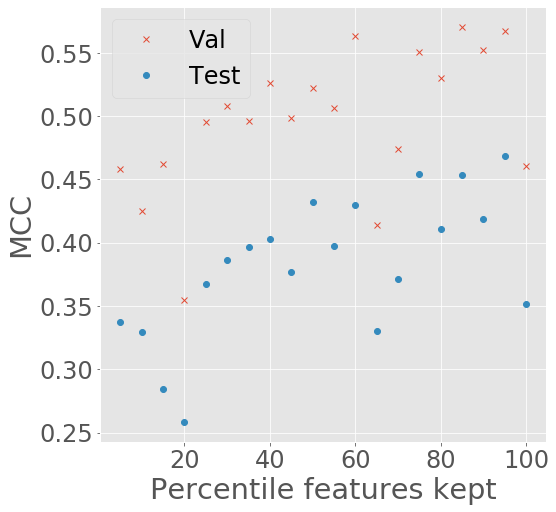

In [15]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

We repeat the same with a SVM model

Validation set with 5 percentile, 103 features
NER: 0.766, Sensitivity or recall: 0.653, Specificity: 0.879, Precision: 0.718, Correctly calssified: 0.806, MCC: 0.546
Testing
NER: 0.694, Sensitivity or recall: 0.545, Specificity: 0.843, Precision: 0.663, Correctly calssified: 0.736, MCC: 0.408
Validation set with 10 percentile, 205 features
NER: 0.757, Sensitivity or recall: 0.639, Specificity: 0.875, Precision: 0.708, Correctly calssified: 0.799, MCC: 0.529
Testing
NER: 0.696, Sensitivity or recall: 0.564, Specificity: 0.827, Precision: 0.649, Correctly calssified: 0.732, MCC: 0.405
Validation set with 15 percentile, 307 features
NER: 0.752, Sensitivity or recall: 0.658, Specificity: 0.847, Precision: 0.670, Correctly calssified: 0.786, MCC: 0.507
Testing
NER: 0.705, Sensitivity or recall: 0.592, Specificity: 0.819, Precision: 0.649, Correctly calssified: 0.737, MCC: 0.420
Validation set with 20 percentile, 409 features
NER: 0.785, Sensitivity or recall: 0.691, Specificity: 0.879, Pre

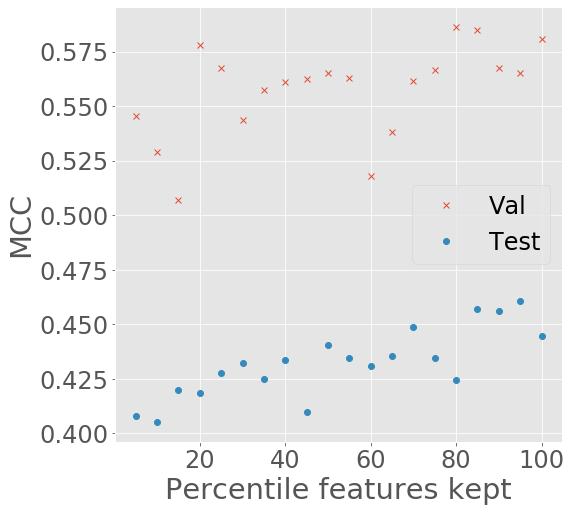

In [16]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    shared_reduced = sel.fit_transform(shared_reduced)
    only_2c9_reduced = sel.transform(only_2c9_reduced)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    svm = SVC(C=8, kernel="rbf")
    svm.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = svm.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = svm.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

In [17]:
print(features_shared.shape, features_only_2c9.shape, features_only_3a4.shape)
print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)

(9420, 2044) (2813, 2044) (2994, 2044)
(9420, 2044) (2813, 2044) (2994, 205)
(9420, 205) (2813, 205) (2994, 205)


In [18]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [19]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(2, 6))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete(list(range(10, 61, 10))))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))

os.makedirs("hyperparameters_tunning/morgan_fingerprints_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy')])
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    model.fit(train_data, train_labels, epochs=10, verbose=2)
    _, results = model.evaluate(test_data, test_labels)
    return results

def run(run_dir, hparams):
      if os.path.exists(run_dir):
        return
      with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar("accuracy", accuracy, step=1)

In [20]:
if hyperparam_tunning:
    session_num = 0
    total_runs = len(HP_NEURONS.domain.values)*len(HP_HIDDEN_LAYERS.domain.values)*len([HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value])*len(HP_OPTIMIZER.domain.values)*len([HP_L2.domain.min_value, HP_L2.domain.max_value])*len(HP_LR.domain.values)
    looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

In [21]:
%tensorboard --logdir hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning

In [22]:
hidden_layers = 4
neurons = 40
dropout = 0.2
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.Adam()
L2 = 0.010000

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 4s 18ms/step - loss: 1.2717 - binary_accuracy: 0.7223
Epoch 2/10
221/221 [==============================] - 4s 19ms/step - loss: 0.6951 - binary_accuracy: 0.7820
Epoch 3/10
221/221 [==============================] - 4s 18ms/step - loss: 0.5726 - binary_accuracy: 0.8125
Epoch 4/10
221/221 [==============================] - 4s 17ms/step - loss: 0.4935 - binary_accuracy: 0.8309
Epoch 5/10
221/221 [==============================] - 4s 18ms/step - loss: 0.4406 - binary_accuracy: 0.8459
Epoch 6/10
221/221 [==============================] - 4s 17ms/step - loss: 0.4061 - binary_accuracy: 0.8536
Epoch 7/10
221/221 [==============================] - 4s 17ms/step - loss: 0.3740 - binary_accuracy: 0.8698
Epoch 8/10
221/221 [==============================] - 4s 17ms/step - loss: 0.3481 - binary_accuracy: 0.8750
Epoch 9/10
221/221 [==============================] - 4s 17ms/step - loss: 0.3212 - binary_accuracy: 0.8896
Epoch 10/10
221/221 [=======

Try the same NN with another feature selection method

In [23]:
# print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [24]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 4s 17ms/step - loss: 1.0000 - binary_accuracy: 0.7022
Epoch 2/10
221/221 [==============================] - 4s 17ms/step - loss: 0.6483 - binary_accuracy: 0.7875
Epoch 3/10
221/221 [==============================] - 4s 17ms/step - loss: 0.5584 - binary_accuracy: 0.8163
Epoch 4/10
221/221 [==============================] - 4s 17ms/step - loss: 0.5057 - binary_accuracy: 0.8277
Epoch 5/10
221/221 [==============================] - 4s 17ms/step - loss: 0.4649 - binary_accuracy: 0.8413
Epoch 6/10
221/221 [==============================] - 4s 17ms/step - loss: 0.4188 - binary_accuracy: 0.8582
Epoch 7/10
221/221 [==============================] - 4s 17ms/step - loss: 0.3806 - binary_accuracy: 0.8733
Epoch 8/10
221/221 [==============================] - 4s 18ms/step - loss: 0.3464 - binary_accuracy: 0.8851
Epoch 9/10
221/221 [==============================] - 4s 17ms/step - loss: 0.3320 - binary_accuracy: 0.8897
Epoch 10/10
221/221 [=======

In [25]:
# print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced_comb, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [27]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced_comb)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.7050 - binary_accuracy: 0.7166
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5279 - binary_accuracy: 0.7439
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5088 - binary_accuracy: 0.7541
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4913 - binary_accuracy: 0.7699
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4798 - binary_accuracy: 0.7793
Epoch 6/10
221/221 [==============================] - 1s 6ms/step - loss: 0.4639 - binary_accuracy: 0.7921
Epoch 7/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4405 - binary_accuracy: 0.8100
Epoch 8/10
221/221 [==============================] - 1s 7ms/step - loss: 0.4118 - binary_accuracy: 0.8381
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.3846 - binary_accuracy: 0.8545
Epoch 10/10
221/221 [================

In [29]:
kernel = "rbf"
C_values = np.geomspace(0.1, 100, num=20)
for c in C_values:
    svm = SVC(C=c, kernel=kernel)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(val_data)
    print(f"Scores using C={c} for validation")
    print_metrics(predicted, val_labels)
    predictions = svm.predict(only_2c9_reduced_comb)
    print("  Scores for testing")
    print_metrics(predictions, labels_testing_2c9);

Scores using C=0.1 for validation
NER: 0.634, Sensitivity or recall: 0.336, Specificity: 0.932, Precision: 0.700, Correctly calssified: 0.740, MCC: 0.346
  Scores for testing
NER: 0.588, Sensitivity or recall: 0.256, Specificity: 0.919, Precision: 0.642, Correctly calssified: 0.680, MCC: 0.240
Scores using C=0.14384498882876628 for validation
NER: 0.672, Sensitivity or recall: 0.427, Specificity: 0.917, Precision: 0.708, Correctly calssified: 0.759, MCC: 0.406
  Scores for testing
NER: 0.603, Sensitivity or recall: 0.309, Specificity: 0.897, Precision: 0.629, Correctly calssified: 0.685, MCC: 0.259
Scores using C=0.20691380811147897 for validation
NER: 0.694, Sensitivity or recall: 0.482, Specificity: 0.906, Precision: 0.709, Correctly calssified: 0.770, MCC: 0.439
  Scores for testing
NER: 0.622, Sensitivity or recall: 0.361, Specificity: 0.883, Precision: 0.636, Correctly calssified: 0.695, MCC: 0.291
Scores using C=0.29763514416313175 for validation
NER: 0.713, Sensitivity or recall